In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from transformers import HubertModel, HubertForSequenceClassification
from transformers import TrainingArguments, Trainer, AutoModel
from transformers import TrainerCallback, IntervalStrategy
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.utils.class_weight import compute_class_weight


In [2]:
df = pd.read_pickle('Annomi_HuBERT_with_attention_mask.pkl')

In [3]:
# Get a dataframe where interlocutor is cleint
df_client = df[df['interlocutor'] == 'client']

In [4]:
# Split the df_therapist into train and test sets depending on the unique id of video_title
# The train set contains 80% of the data and the test set contains 20% of the data

video_titles = df_client['video_title'].unique()

train_video_titles, test_video_titles = train_test_split(video_titles, test_size=0.2, random_state=42)

train_df = df_client[df_client['video_title'].isin(train_video_titles)]
test_df = df_client[df_client['video_title'].isin(test_video_titles)]

In [5]:
# labeling the y_train and y_test
y_train_classes = train_df['client_talk_type']
le = preprocessing.LabelEncoder()
le.fit(y_train_classes)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y_train = le.transform(y_train_classes)
y_test_classes = test_df['client_talk_type']
y_test = le.transform(y_test_classes)

Original classes ['change' 'neutral' 'sustain']
Corresponding numeric classes [0 1 2]


In [6]:
# X_train and X_test

X_train = train_df['client_hubert_emb'].to_numpy()
X_test = test_df['client_hubert_emb'].to_numpy()

In [7]:
X_train_tensors = [e["input_values"] for e in X_train]
X_test_tensors = [e["input_values"] for e in X_test]
y_train_tensors = torch.tensor(y_train).long()
y_test_tensors = torch.tensor(y_test).long()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Assuming y_train is your original numpy array of labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.FloatTensor(class_weights).to(device)

In [10]:
model = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-ks").to(device)

In [11]:
model.classifier = nn.Linear(in_features=256, out_features=3, bias=True)
model = model.to(device)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.weight = weight  # New line

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy_with_logits(inputs, targets, reduction='none', weight=self.weight)
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


In [13]:
train_dataset = CustomDataset(X_train_tensors, y_train_tensors)
test_dataset = CustomDataset(X_test_tensors, y_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 100
model.train()

epoch_train_losses = []
epoch_val_losses = []
epoch_train_f1s = []
epoch_val_f1s = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    # Training loop
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        batch_embeddings, batch_labels = batch
        
        # Move tensors to GPU if CUDA is available
        batch_embeddings = batch_embeddings.to(device)
        batch_embeddings = batch_embeddings.squeeze(1)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_values=batch_embeddings)
        logits = outputs.logits
        loss = criterion(logits, batch_labels)
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        # For F1 score, gather all predictions and labels for training set
        all_train_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_train_labels.extend(batch_labels.cpu().numpy())
    
    train_loss = total_train_loss / len(train_loader)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    epoch_train_losses.append(train_loss)
    epoch_train_f1s.append(train_f1)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validating"):
            batch_embeddings, batch_labels = batch
            
            batch_embeddings = batch_embeddings.to(device)
            batch_embeddings = batch_embeddings.squeeze(1)
            batch_labels = batch_labels.to(device)
            
            outputs = model(input_values=batch_embeddings)
            logits = outputs.logits
            loss = criterion(logits, batch_labels)
            
            total_val_loss += loss.item()

            # For F1 score, gather all predictions and labels for validation set
            all_val_preds.extend(logits.argmax(dim=1).cpu().numpy())
            all_val_labels.extend(batch_labels.cpu().numpy())

    val_loss = total_val_loss / len(test_loader)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
    epoch_val_losses.append(val_loss)
    epoch_val_f1s.append(val_f1)

    print(f"Epoch {epoch + 1} Train loss: {train_loss}, Train F1 Score: {train_f1}, \nValidation Loss: {val_loss}, Validation F1 Score: {val_f1}")



Epoch 1/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

/root/miniconda3/envs/mlStuff/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1 Train loss: 0.8952796172078062, Train F1 Score: 0.26091563041504834, 
Validation Loss: 0.9845196932986162, Validation F1 Score: 0.2366863905325444


Epoch 2/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 2/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2 Train loss: 0.8888437949666163, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9838973789111428, Validation F1 Score: 0.2366863905325444


Epoch 3/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 3/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3 Train loss: 0.8882346380411125, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9895771849846494, Validation F1 Score: 0.2366863905325444


Epoch 4/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 4/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4 Train loss: 0.8879773629511275, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9693163737006809, Validation F1 Score: 0.2366863905325444


Epoch 5/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 5/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 5 Train loss: 0.8877265309778656, Train F1 Score: 0.26012859245487646, 
Validation Loss: 1.0106039375498674, Validation F1 Score: 0.2366863905325444


Epoch 6/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 6/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 6 Train loss: 0.888009553002875, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9660655368065488, Validation F1 Score: 0.2366863905325444


Epoch 7/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 7/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 7 Train loss: 0.8883145309802962, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.98538463746292, Validation F1 Score: 0.2366863905325444


Epoch 8/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 8/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 8 Train loss: 0.8882708398670685, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9675230176552482, Validation F1 Score: 0.2366863905325444


Epoch 9/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 9/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 9 Train loss: 0.8874800743126288, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9815253731997117, Validation F1 Score: 0.2366863905325444


Epoch 10/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 10/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 10 Train loss: 0.8862266079863397, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9881033931953319, Validation F1 Score: 0.2366863905325444


Epoch 11/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 11/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 11 Train loss: 0.8878125664664478, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9859401721885239, Validation F1 Score: 0.2366863905325444


Epoch 12/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 12/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 12 Train loss: 0.8870202092135825, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9815115315326746, Validation F1 Score: 0.2366863905325444


Epoch 13/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 13/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 13 Train loss: 0.8870688158927894, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9764001110325689, Validation F1 Score: 0.2366863905325444


Epoch 14/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 14/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 14 Train loss: 0.8867379290665068, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9761506707771964, Validation F1 Score: 0.2366863905325444


Epoch 15/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 15/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 15 Train loss: 0.8870099496732398, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9835861329583154, Validation F1 Score: 0.2366863905325444


Epoch 16/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 16/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 16 Train loss: 0.8866947855709529, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9749406515688136, Validation F1 Score: 0.2366863905325444


Epoch 17/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 17/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 17 Train loss: 0.8866310161424846, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9723860250003096, Validation F1 Score: 0.2366863905325444


Epoch 18/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 18/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 18 Train loss: 0.8875649811291113, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9692532359689906, Validation F1 Score: 0.2366863905325444


Epoch 19/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 19/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 19 Train loss: 0.8872587867989773, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9919502549413322, Validation F1 Score: 0.2366863905325444


Epoch 20/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 20/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 20 Train loss: 0.8868070059433216, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9756393639937692, Validation F1 Score: 0.2366863905325444


Epoch 21/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 21/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 21 Train loss: 0.8867016279297631, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9692253867785136, Validation F1 Score: 0.2366863905325444


Epoch 22/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 22/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 22 Train loss: 0.8872187931726618, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9857860764731532, Validation F1 Score: 0.2366863905325444


Epoch 23/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 23/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 23 Train loss: 0.8866898017685588, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.995457135680793, Validation F1 Score: 0.2366863905325444


Epoch 24/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 24/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 24 Train loss: 0.8859470937310195, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9789846504943959, Validation F1 Score: 0.2366863905325444


Epoch 25/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 25/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 25 Train loss: 0.8868440444149622, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9692022135292274, Validation F1 Score: 0.2366863905325444


Epoch 26/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 26/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 26 Train loss: 0.8870093124668773, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9871689184852268, Validation F1 Score: 0.2366863905325444


Epoch 27/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 27/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 27 Train loss: 0.8873326362269681, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9697189063265703, Validation F1 Score: 0.2366863905325444


Epoch 28/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 28/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 28 Train loss: 0.8865424203799992, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9754485734131025, Validation F1 Score: 0.2366863905325444


Epoch 29/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 29/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 29 Train loss: 0.8861996214382533, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9738177704638329, Validation F1 Score: 0.2366863905325444


Epoch 30/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 30/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 30 Train loss: 0.8864371916506348, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9772788208463917, Validation F1 Score: 0.2366863905325444


Epoch 31/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 31/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 31 Train loss: 0.8862840544159819, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9869563065577245, Validation F1 Score: 0.2366863905325444


Epoch 32/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 32/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 32 Train loss: 0.8872426833684851, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9780574341615041, Validation F1 Score: 0.2366863905325444


Epoch 33/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 33/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 33 Train loss: 0.8860702999844784, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9744153113468833, Validation F1 Score: 0.2366863905325444


Epoch 34/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 34/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 34 Train loss: 0.8869591846880389, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9844564242639403, Validation F1 Score: 0.2366863905325444


Epoch 35/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 35/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 35 Train loss: 0.8873190879821777, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.981616726388102, Validation F1 Score: 0.2366863905325444


Epoch 36/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 36/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 36 Train loss: 0.8862980924001554, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9823354845461638, Validation F1 Score: 0.2366863905325444


Epoch 37/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 37/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 37 Train loss: 0.8865174760178822, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.976930786734042, Validation F1 Score: 0.2366863905325444


Epoch 38/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 38/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 38 Train loss: 0.8873860950513583, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9795707377834596, Validation F1 Score: 0.2366863905325444


Epoch 39/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 39/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 39 Train loss: 0.8870502577685728, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9884306844593822, Validation F1 Score: 0.2366863905325444


Epoch 40/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 40/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 40 Train loss: 0.886335269434423, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9790572865285735, Validation F1 Score: 0.2366863905325444


Epoch 41/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 41/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 41 Train loss: 0.8860365212327097, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9763101546660714, Validation F1 Score: 0.2366863905325444


Epoch 42/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 42/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 42 Train loss: 0.8861609825455561, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9770767611006032, Validation F1 Score: 0.2366863905325444


Epoch 43/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 43/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 43 Train loss: 0.8866946876230763, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9804135003815526, Validation F1 Score: 0.2366863905325444


Epoch 44/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 44/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 44 Train loss: 0.8856362400621902, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9868808488051096, Validation F1 Score: 0.2366863905325444


Epoch 45/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 45/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 45 Train loss: 0.8865975802991448, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9796959999678791, Validation F1 Score: 0.2366863905325444


Epoch 46/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 46/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 46 Train loss: 0.8867511536653448, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9767506938913594, Validation F1 Score: 0.2366863905325444


Epoch 47/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 47/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 47 Train loss: 0.8866134224141516, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9722291140452676, Validation F1 Score: 0.2366863905325444


Epoch 48/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 48/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 48 Train loss: 0.8862940916200963, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9779356553934623, Validation F1 Score: 0.2366863905325444


Epoch 49/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 49/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 49 Train loss: 0.886392727403379, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9725814306217692, Validation F1 Score: 0.2366863905325444


Epoch 50/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 50/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 50 Train loss: 0.8863168418770884, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9708737856236057, Validation F1 Score: 0.2366863905325444


Epoch 51/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 51/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 51 Train loss: 0.8861292028209058, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9766036047451738, Validation F1 Score: 0.2366863905325444


Epoch 52/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 52/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 52 Train loss: 0.8863283749215487, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9867364893788877, Validation F1 Score: 0.2366863905325444


Epoch 53/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 53/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 53 Train loss: 0.8869306761317137, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9776247316512509, Validation F1 Score: 0.2366863905325444


Epoch 54/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 54/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 54 Train loss: 0.8860228714964739, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.990377315144608, Validation F1 Score: 0.2366863905325444


Epoch 55/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 55/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 55 Train loss: 0.8861250165032177, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9777081202769625, Validation F1 Score: 0.2366863905325444


Epoch 56/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 56/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 56 Train loss: 0.8861340206207299, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9760590364103732, Validation F1 Score: 0.2366863905325444


Epoch 57/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 57/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 57 Train loss: 0.8865104385810655, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9898222753967064, Validation F1 Score: 0.2366863905325444


Epoch 58/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 58/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 58 Train loss: 0.8870356589919184, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9860498257305311, Validation F1 Score: 0.2366863905325444


Epoch 59/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 59/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 59 Train loss: 0.8862577393287565, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9818539308465045, Validation F1 Score: 0.2366863905325444


Epoch 60/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 60/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 60 Train loss: 0.8861268308104538, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9776328024656876, Validation F1 Score: 0.2366863905325444


Epoch 61/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 61/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 61 Train loss: 0.8869040045069485, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9786256772020588, Validation F1 Score: 0.2366863905325444


Epoch 62/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 62/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 62 Train loss: 0.8869339681980086, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9817732913770537, Validation F1 Score: 0.2366863905325444


Epoch 63/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 63/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 63 Train loss: 0.8858448786706459, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9863338142201521, Validation F1 Score: 0.2366863905325444


Epoch 64/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 64/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 64 Train loss: 0.8866050194312887, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9802287462828816, Validation F1 Score: 0.2366863905325444


Epoch 65/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 65/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 65 Train loss: 0.8863526708105716, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.980808152668718, Validation F1 Score: 0.2366863905325444


Epoch 66/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 66/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 66 Train loss: 0.8856854158930663, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9807977015557496, Validation F1 Score: 0.2366863905325444


Epoch 67/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 67/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 67 Train loss: 0.886345361791006, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9834743349448495, Validation F1 Score: 0.2366863905325444


Epoch 68/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 68/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 68 Train loss: 0.8860379070407007, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9750582878140436, Validation F1 Score: 0.2366863905325444


Epoch 69/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 69/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 69 Train loss: 0.8858029737886859, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9858449442663054, Validation F1 Score: 0.2366863905325444


Epoch 70/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 70/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 70 Train loss: 0.8864028119459385, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9812847751638164, Validation F1 Score: 0.2366863905325444


Epoch 71/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 71/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 71 Train loss: 0.8864939379982832, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9706056562886722, Validation F1 Score: 0.2366863905325444


Epoch 72/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 72/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 72 Train loss: 0.8870567692125716, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9733532896076423, Validation F1 Score: 0.2366863905325444


Epoch 73/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 73/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 73 Train loss: 0.8862000302207179, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9738911839498989, Validation F1 Score: 0.2366863905325444


Epoch 74/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 74/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 74 Train loss: 0.8864414048631016, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9746240813663041, Validation F1 Score: 0.2366863905325444


Epoch 75/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 75/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 75 Train loss: 0.8859191500559086, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9752464812734852, Validation F1 Score: 0.2366863905325444


Epoch 76/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 76/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 76 Train loss: 0.886095418526632, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9842144920342211, Validation F1 Score: 0.2366863905325444


Epoch 77/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 77/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 77 Train loss: 0.8857244913716141, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9869938142921614, Validation F1 Score: 0.2366863905325444


Epoch 78/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 78/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 78 Train loss: 0.8866149906705065, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9689790541711061, Validation F1 Score: 0.2366863905325444


Epoch 79/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 79/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 79 Train loss: 0.8861609730051785, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.978704545808875, Validation F1 Score: 0.2366863905325444


Epoch 80/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 80/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 80 Train loss: 0.8858729004859924, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9780281164507935, Validation F1 Score: 0.2366863905325444


Epoch 81/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 81/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 81 Train loss: 0.8864031563081393, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9751941894275554, Validation F1 Score: 0.2366863905325444


Epoch 82/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 82/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 82 Train loss: 0.8864465648444687, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.980841230655062, Validation F1 Score: 0.2366863905325444


Epoch 83/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 83/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 83 Train loss: 0.8860214792373704, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9776758003062096, Validation F1 Score: 0.2366863905325444


Epoch 84/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 84/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 84 Train loss: 0.8859222502243228, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9826436448788297, Validation F1 Score: 0.2366863905325444


Epoch 85/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 85/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 85 Train loss: 0.88604318532275, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9778572830601014, Validation F1 Score: 0.2366863905325444


Epoch 86/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 86/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 86 Train loss: 0.8863337646897246, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9764202586982561, Validation F1 Score: 0.2366863905325444


Epoch 87/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 87/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 87 Train loss: 0.8860913826743277, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9748737246230028, Validation F1 Score: 0.2366863905325444


Epoch 88/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 88/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 88 Train loss: 0.8861970881499895, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.973584935285043, Validation F1 Score: 0.2366863905325444


Epoch 89/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 89/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 89 Train loss: 0.8860301439900223, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9725638122662253, Validation F1 Score: 0.2366863905325444


Epoch 90/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 90/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 90 Train loss: 0.8862046254117314, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9848874859187914, Validation F1 Score: 0.2366863905325444


Epoch 91/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 91/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 91 Train loss: 0.8862032552317876, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9890996891519298, Validation F1 Score: 0.2366863905325444


Epoch 92/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 92/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 92 Train loss: 0.8853868024378289, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9688093243301779, Validation F1 Score: 0.2366863905325444


Epoch 93/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 93/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 93 Train loss: 0.8864929799626513, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9764525462751803, Validation F1 Score: 0.2366863905325444


Epoch 94/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 94/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 94 Train loss: 0.8863682981307913, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9780412100363469, Validation F1 Score: 0.2366863905325444


Epoch 95/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 95/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 95 Train loss: 0.8857523942502533, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9740549446879954, Validation F1 Score: 0.2366863905325444


Epoch 96/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 96/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 96 Train loss: 0.8862253814572241, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9820265320764072, Validation F1 Score: 0.2366863905325444


Epoch 97/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 97/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 97 Train loss: 0.8861491076829957, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9887669246265853, Validation F1 Score: 0.2366863905325444


Epoch 98/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 98/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 98 Train loss: 0.8863941242055196, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9859012650406879, Validation F1 Score: 0.2366863905325444


Epoch 99/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 99/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 99 Train loss: 0.8860919794476614, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.9938695534415867, Validation F1 Score: 0.2366863905325444


Epoch 100/100 - Training:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 100/100 - Validating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 100 Train loss: 0.8860590738675943, Train F1 Score: 0.26012859245487646, 
Validation Loss: 0.984846439914427, Validation F1 Score: 0.2366863905325444


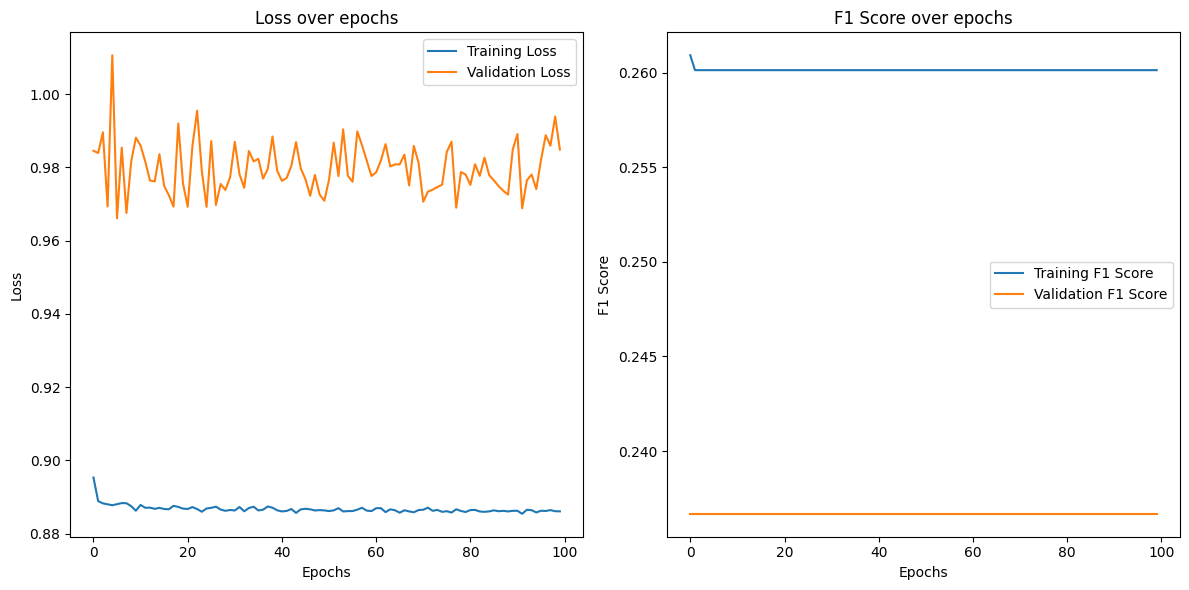

In [15]:
# Plotting Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting F1 Score
plt.subplot(1, 2, 2)
plt.plot(epoch_train_f1s, label='Training F1 Score')
plt.plot(epoch_val_f1s, label='Validation F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch_embeddings, batch_labels = batch
        batch_embeddings = batch_embeddings.to(device).squeeze(1)
        batch_labels = batch_labels.to(device)

        outputs = model(input_values=batch_embeddings)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

        all_predictions.extend(predictions)
        all_true_labels.extend(batch_labels.cpu().numpy())


f1_macro = f1_score(all_true_labels, all_predictions, average='macro')
print(f"Macro-average F1 Score: {f1_macro}")

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Macro-average F1 Score: 0.2366863905325444
